# Gold Prediction ARIMA-GARCH semi model

Hello there! Thanks for coming here, I'm Franck Bui Nguyen.

email : franck5nguyen@gmail.com

Abstract: This study focuses on the gold prices from Jan-2019 until Sept-2020. Data  

Gold has always been seen as a safe heaven during time of uncertainty. It was the case during the 2008 crisis and for a more closer example: the Coronavirus. Indeed since the begining of april, financial market has been impacted by depression like never before. But it has also never seen such a bullish run. 2020 will be remembered as one of the most turbulant year in financial history and will provide a lot of data to play with.<br>


The purpose of this paper is to: 

1) understand the different variable that can affect the gold spot price and the interraction with all other asset classes from commodities to equities and forex

2) Forecast gold spot price on a short term (about 1 month in the future) using several paper research 
* https://www.researchgate.net/publication/324273329_Trading_gold_future_with_ARIMA-GARCH_model <br>
* https://otexts.com/fpp2/


Note : Main languages used are Python, C++ and some R

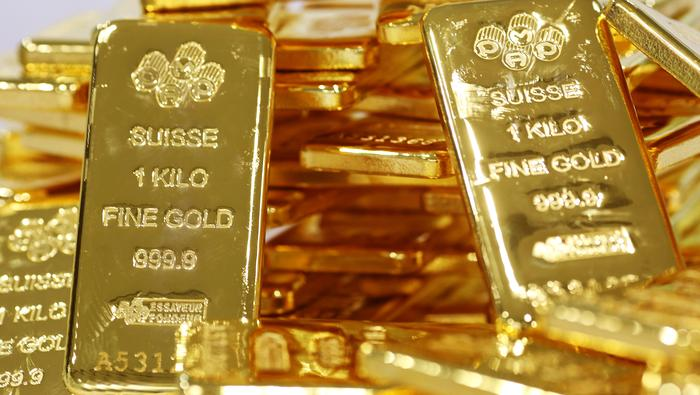

In [8]:
Image(filename="Image\Gold.jpg")

# Summary
* Forecasting using ARIMA(P,D,Q)
* Presentation GARCH(P,Q)
* Forecasting using hybrid ARIMA-GARCH model
* Coronavirus impact on financial market and correlation studies

# Time Series

The idea is to use past data in order to predict the future, lets take for example a weather forecast for next week. The question would be : *Until when should I look in the past in order to predict the future?*.<br>
It is not reasonable to take weather data from 2010 right? Then until when should I look to make my prediction as close as possible to reality?<br>
Our main tool to study the gold price is time series analysis and the main models will be ARMA/ARIMA and GARCH which feets our need.


## Additive vs Multiplicative model
### Additive model 
$$X_t = trend_t + seasonal_t + residual_t$$
$$\Delta X_t = X_t - X_{t-1}  = $$


Additive model is useful when the seasonal variation is relatively constant over time

### Multiplicative model 
Multiplicative model is useful when the seaosnal variation increases over time
$$ X_t =trend_t*seasonal_t*error_t$$
$$ ln(X_t) = ln(trend_t)+ln(seasonal_t)+ln(error_t)$$
$$ ln(return) = ln(X_t) - ln(X_{t-1}) = ln(\frac{X_t}{X_{t-1}}) $$



In [4]:
import dataMngt as dtmgt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsParam as stsp
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch as engle
from sklearn.metrics import mean_squared_error
from IPython.display import Image
import math
from arch import arch_model
from scipy.stats import t
import scipy.stats as stats
import warnings;
#warnings.filterwarnings('ignore');#Disable warning

In [23]:
#get gold data from 2006 till now
all = pd.read_csv(r'C:\Coding\Python Project\Stocks\Data\stock.csv',index_col=False)

#Calculate correlation between each asset starting from corrDate
corrDate = "2020-01-01"

EQD = all.loc[(all.type == 'EQD')&(all.date>corrDate)]
EQDmarket = all.loc[(all.underlying0 == "EquityMarket")&(all.date>corrDate)]
CTY = all.loc[(all.type == 'CTY')&(all.date>corrDate)]
FX = all.loc[(all.type == 'FX')&(all.date>corrDate)]

allFormat = dtmgt.unstackData(all)
EQDFormat = dtmgt.unstackData(EQD,typeList = ['EQD'])
CTYFormat = dtmgt.unstackData(CTY,typeList = ['CTY'])
FXFormat = dtmgt.unstackData(FX,typeList = ['FX'])

First lets have a look at the data of the gold price from Jan-2005 until Sept-2020. Though we will not use all the data for our analysis but having an overall idea of the shape of what the price look like can give us an intuition on how to proceed. Second we might need data from the last 2008 financial crisis to predict our data as we are currntly going through a rough time.

  type      underlying0 underlying underlying1        date       price
0  CTY  Precious Metals       Gold         XAU  2005-01-03  428.700012
1  CTY  Precious Metals       Gold         XAU  2005-01-04  428.500000
2  CTY  Precious Metals       Gold         XAU  2005-01-05  426.600006
3  CTY  Precious Metals       Gold         XAU  2005-01-06  421.000000
4  CTY  Precious Metals       Gold         XAU  2005-01-07  418.899994


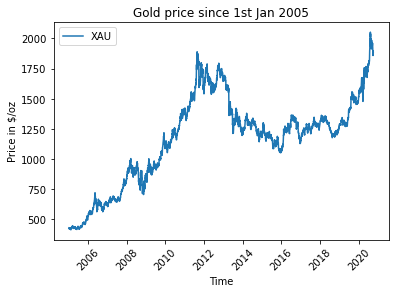

In [24]:
print(all.head())
xau = allFormat[['XAU']] #Gold price

sns.lineplot(data=xau)
plt.title("Gold price since 1st Jan 2005")
plt.xlabel('Time')
plt.ylabel('Price in $/oz')
plt.xticks(rotation=45);


# ARIMA(P,D,Q) Model

The autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series. ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.

**Definition : Stationarity**

A stationary time series do not depend on the time at which the series is observed. Stationarity has 2 forms, its weak and strong form.<br>

*Weak*<br>
A time series is stationary in its weak form if its statisics do not vary and are independant from time at each instant it is observed. Statistics can be its variance or its mean throughout time.<br>
For example white noise is stationary

*Strong*<br>
A time series is stationary in its strong form if the density law of $X_t$ at a time t is the same if look at $X_{t+\epsilon}$

That is $X_t$ is stationary if $$\forall t \in [0,T], \mathcal{L}(X_t) = \mathcal{L}(X_{t+\epsilon}), \forall \epsilon > 0$$

with <br>
$\mathcal{L}(X_t)$ the density of X at time t<br>
$\epsilon$ an infinitysimal time laps with $\epsilon \rightarrow 0$

## Integrated(D)

The integration(D) represent the number of differencing operator we need to apply on the data to make it stationary.<br>

By using the following transform,
$$\bar{X_t} = \Delta_t = X_t - X_{t-1}$$

Let $X_t$ be a time series with $t$ the time I am looking at and $X_t$ it's value.


Before jumping heads on the hard stuff, we need to figure out which out of the additive and the multiplicative model is the most accurate. Lets first have a look at the price since 2019-01-01 until now.

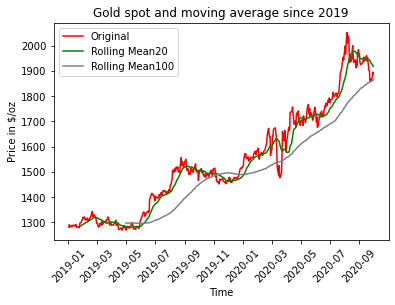

In [25]:
xau = xau[xau.index>="2019-01-01"].dropna() # Filter for 2020 only
rolling_mean20 = xau.XAU.rolling(20).mean()
rolling_mean100 = xau.XAU.rolling(100).mean()

plt.plot(xau, color = 'red', label = 'Original')
plt.plot(rolling_mean20, color = 'green', label = 'Rolling Mean20')
plt.plot(rolling_mean100, color = 'grey', label = 'Rolling Mean100')

plt.legend(loc = 'best')
plt.title('Gold spot and moving average since 2019')
plt.xlabel('Time')
plt.ylabel('Price in $/oz')
plt.xticks(rotation=45);

The above plot represents an overall shape of the gold price since 2019 (closed price. <br>
Without using any mathematics, we can clearly see a tendency throughout time, that is overall the price has been increasing over the months. Moreover if we look closely, both moving average 20 and 100 days keep increasing as time passes by.

We can first sniff out that this time series might not be a stationary one, if we look at an interval between 2 months in 2019, we can clearly see that the average 1 year later is not the same. Lets prove it mathematically with a statistics test using the augmented Dickey Fuller test

H0 : The time series is not stationary 

H1 : The time series is stationary



In [26]:
stsp.stationary_test(xau)

Results of Dickey-Fuller Test:
Test Statistic                  -0.219530
p-value                          0.936153
No. Lags Used                   10.000000
Number of Observations Used    510.000000
Critical value (1%)             -3.443237
Critical value (5%)             -2.867224
Critical value (10%)            -2.569797
dtype: float64


From the above result, we have a significant p-value which means that the probability to reject incorrectly H0 is high. We deduce that the time series is **not stationary**. This is what we have already proved just by looking at it but I now prove it mathematicaly.<br>
Data needs to be processed to remove the tendency and seasonality and to do this we will apply various transform such as the differenciation.

$$\Delta X_t = X_t - X_{t-1}  = $$

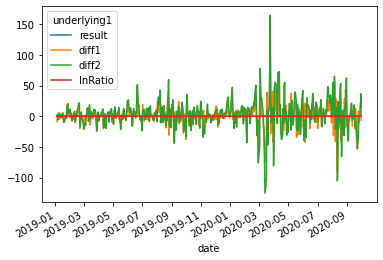

In [27]:
xauTransform = xau.copy()
xauTransform['result'] = xauTransform['XAU'].pct_change()
xauTransform['diff1'] = xauTransform['XAU'].diff(1)
xauTransform['diff2'] = xauTransform['XAU'].diff(2)

xauTransform['lnRatio'] = np.log(xauTransform['XAU'] / xauTransform['XAU'].shift(1))
xauTransform = xauTransform.dropna()
#xauTransform['logResult'] = np.log(xauTransform.result)
xauTransform.drop(columns='XAU',inplace=True)
xauTransform.plot();




In [28]:
stsp.stationary_test(xauTransform.diff1)

Results of Dickey-Fuller Test:
Test Statistic                -8.013379e+00
p-value                        2.171166e-12
No. Lags Used                  9.000000e+00
Number of Observations Used    5.090000e+02
Critical value (1%)           -3.443263e+00
Critical value (5%)           -2.867235e+00
Critical value (10%)          -2.569803e+00
dtype: float64


From the above, ADF gives us
$$ TValue < C_1 < C_5 < C_{10} < PValue$$
Time series is stationary ?

We deduce that **D = 1**

## Auto-Regressive(P)

Def : Let $X_t$ be a processus. $X_t$ is autoregressive if the present value is weighted average of its past values. In other term, 
$$ X_t = \sum^p_{i=1}\alpha_i X_{t-i} + \epsilon_t$$
with:<br>
$\epsilon_t$ white noise $\mathcal{L}(0,\sigma^2), \sigma< \infty$<br>
$\theta_i$ parameter of the model<br>
p: The number of lag obsevations included in the model, also called the lag order

ACF strong for lag k the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.<br>
PACF We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

## Moving Average(Q)

Def : Let $X_t$ be a processus, $X_t$ is a moving average process if the present value of series is defined as a linear combination of past errors. The processys corrects itself depending on the previous error until the q-eme.

$X_t$ can also be writen as:
$$ X_t = \sum^q_{i=1}\theta_i \epsilon_{t-i} + \epsilon_t$$
with:<br>
$\epsilon_t$ white noise $\mathcal{L}(0,\sigma^2), \sigma < \infty$<br>
$\alpha_i$ parameter of the model<br>
q: the size of the moving average window, also called the order of moving average



ACF strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation.

PACF  we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

## ARMA(P,Q) Model
Given a time series of data $X_t$ , the ARMA model is a tool for understanding the future values of $X_t$. The AR part involves regressing the variable on its past values. The MA part involves modeling the error term as a linear combination of error terms occurring contemporaneously and at various times in the past.

$$X_t - \alpha_{1} X_{t-1}-...- \alpha_p X_{t-p} = \epsilon_{t} + \theta_1 \epsilon_{t-1} + .... + \theta_q \epsilon_{t-q}$$
$$ X_t = \underbrace{\sum^p_{i=1}\alpha_i X_{t-i}}_{AR(P)} + \underbrace{\sum^q_{i=1}\theta_i \epsilon_{t-i}}_{MA(Q)}$$


## Autocorrelation function

Def: The autocorrelation is the correlation of a signal with a delayed copy of itself as a function of delay. It is mainly used for finding repeating patterns,such as the presence of a periodic signal obscured by noise.

We find optimum features or order of the MA(Q) process using the ACF plot, as being an MA process it doesn’t have seasonal and trend components so we get only the residual relationship with the lags of time series in the ACF plot.

## Partial-Autocorrelation function

Def: The partial auto-correlation  finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag.

We find optimum features or order of the AR(P) process using the PACF plot, as it removes variations explained by earlier lags so we get only the relevant features.


Lets find out the parameters of our model by looking at the ACF and the PACF.

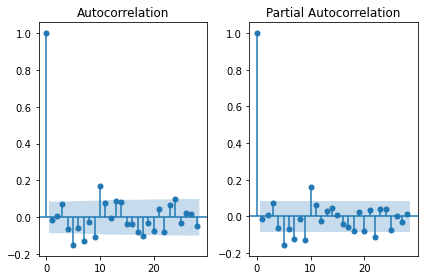

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2)

plot_acf(xauTransform.diff1,ax=ax[0])

plot_pacf(xauTransform.diff1,ax=ax[1])

plt.tight_layout()
plt.show()

From the above we can see a first spike at 0 lag for both plots. It is normal as it represents the correlation with itself and it will always be 1.

We see a drop after lag 3, we deduce:<br>
AR(p) = 3 <br>
MA(q) = 3 <br>

We will then choose the ARIMA(3,1,3) to predict our gold price.

## Train test data split

The train-test split is a technique for evaluating the performance of a machine learning algorithm.
It can be used for classification or regression problems and can be used for any supervised learning algorithm.The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

-Train Dataset: Used to fit the machine learning model.<br>
-Test Dataset: Used to evaluate the fit machine learning model.

The objective is to estimate the performance of the machine learning model on new data: data not used to train the model. This is how we expect to use the model in practice. Namely, to fit it on available data with known inputs and outputs, then make predictions on new examples in the future where we do not have the expected output or target values. The pivot date will be the date that split the data in half.

In [30]:
pivotDate = "2020-08-23" #Split data before Jan-2020 and after
train = xau[xau.index < pivotDate].copy() #Train sample from 2019-01-01 until 2020-01-01
test = xau[xau.index >= pivotDate].copy() #test sample from 2020-01-01 onward


# Prediction

## Model fitting
Model fitting is a measure of how well a machine learning model generalizes to similar data to that on which it was trained. A model that is well-fitted produces more accurate outcomes. A model that is overfitted matches the data too closely. A model that is underfitted doesn’t match closely enough. We will see below how to deal with overfitting

We now fit our model ARIMA(3,1,3) on our training sample and will back test on the rest of the data. 

C:\Users\Franck\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Franck\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


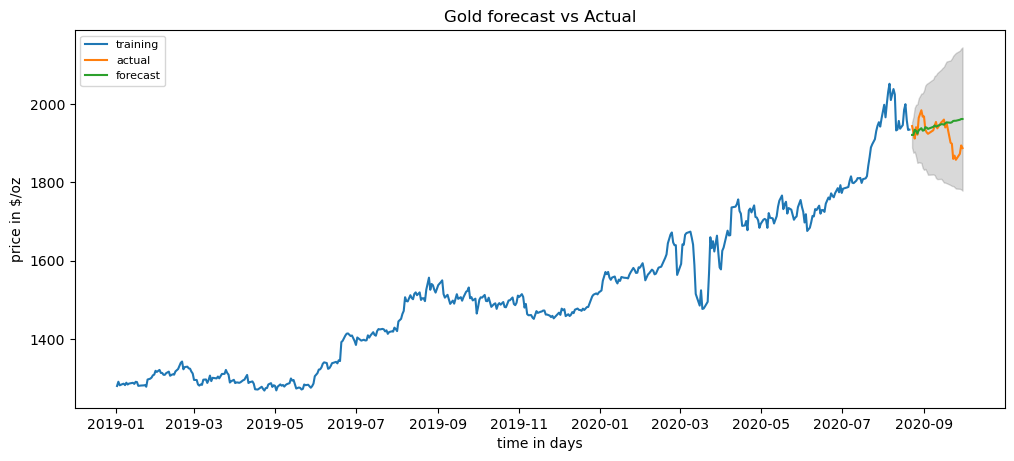

In [31]:
model = ARIMA(train, order=(3,1,3))#FREQ Parameter needs to be checked !!!
fit = model.fit(disp=0);
predict = fit.predict()
sizePredict = len(test)
fc, se, conf = fit.forecast(sizePredict, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)

plt.title('Gold forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('time in days')
plt.ylabel('price in $/oz')
plt.show()


Lets focus on the back testing sample

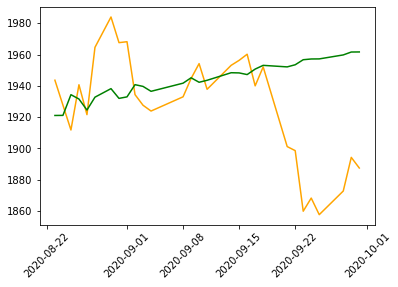

In [32]:
plt.plot(test, label='actual',color="orange")
plt.plot(fc_series, label='forecast',color="green")
plt.xticks(rotation=45);

# Calibration

The goal in this part is to callibrate our model, that is find the optimal parameter (p,d,q) 

# Model validation

The goal of this part is to validate the model by comparing the selected model with other different one. We will assess it through statistical tests.

## Root Mean Squared Error(RMSE)

The RMSE is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. These deviations are called residuals when the calculations are performed over the data sample that was used for estimation and are called errors (or prediction errors) when computed out-of-sample. The RMSD serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power.<br>
Let $ \hat{\theta} $ be the estimator of $\theta$,

$$RMSE(\hat{\theta})=\sqrt{\frac{\sum^n_{i=1}(\hat{y}_i-y_i)^2}{n}}$$

with:<br>
y=actual target<br>
$\hat{y}$=predicted target<br>

In our cases, the RMSE for the ARIMA(3,1,3) model for our test sample is : 44.76

In [33]:
print("RMSE Test set ARIMA(3,1,3) : ",np.sqrt(mean_squared_error(test,fc)))

RMSE Test set ARIMA(3,1,3) :  44.76040570062414


# Overfitting and Underfitting

## Overfitting
Overfitting refers to a model that models the training data too well.

Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.

## Underfitting
Underfitting refers to a model that can neither model the training data nor generalize to new data.

An underfit machine learning model is not a suitable model and will be obvious as it will have poor performance on the training data.

The goal to validate a good model is to find the sweet spot between Overfitting and Underfitting, however usually the main issue comes from Overfitting and there are several way to deal with this.

OUT SAMPLING AND IN SAMPLING

Back testing

# Conclusion

Our main goal is to predict the gold price within a near future. We have applied several test to understand the behavior of the data. In the end we've come to an ARIMA(3,1,3) model where we fitted the model on a train sample(until a pivot date) and tested on the rest of the sample. Overall the tendancy for the first prediction seems to be on the same track, the model was not able to predict the sell-off that happened around the 20th of september-2020.<br>
There are couple of things to do before moving in. We need to first, calibrate our model and find out the optimal parameter (p,d,q), cross validate it and try out-sampling and in-sampling.

It is no where near the objective that we are looking for, but what are we missing then? There are a couple of things to be addressed.<br>
- The law of the residuals<br>
- The volatility of the underlying
- Coronavirus impact on the market

The main draw back of an ARIMA model is that it does not capture the volatility of a stock price. Within the financial market, a simple ARIMA model is not enough to predict accurately. The main issue is : sell-off. Indeed the ARIMA model capture "only" the first moment of a random process but does not capture the conditional volatility that is often seen in finance. The main driver is that usually a small movement in the asset implies a greater variance.<br>
For example when the gold drops below a certain threshold, stop-losses will be triggered creating an even more significant drop. The ARIMA model does not capture conditional variance. 

# Coronavirus 
The coronavirus hitted financial market around early April 2020 as we can clearly see the deep. During the following month, gold has seen an un-precedented bullish market. The first reason is that during time of uncertainty, investissors wish to hedge themselves against various factors, for example the power of a money can severely decrease if a country is heated severely by the crisis or hedging against potential volatil underlying asset. One way to do so is to invest in safe heavens and for ages, gold has proven to be safe and especially in emerging countries. It is a well known fact that underlying usually do not have any correlatio between each other except some of them. However during a crisis, assets start to correlate between each other.

The goal of this section is to find the impact of the coronavirus on the financial market in order to find any pattern or relevant information that we can use.

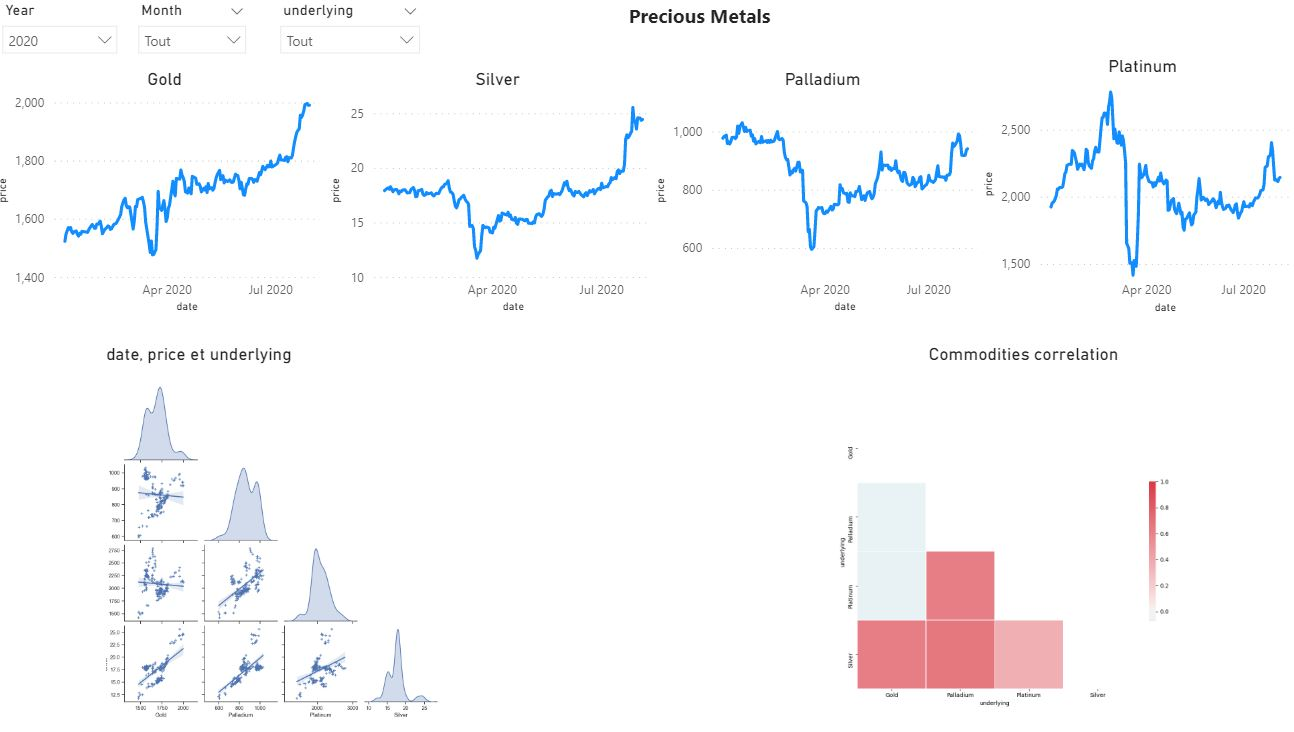

In [7]:
Image(filename="Image\Equities Market.jpg")
Image(filename="Image\Precious Metals.jpg")

[]

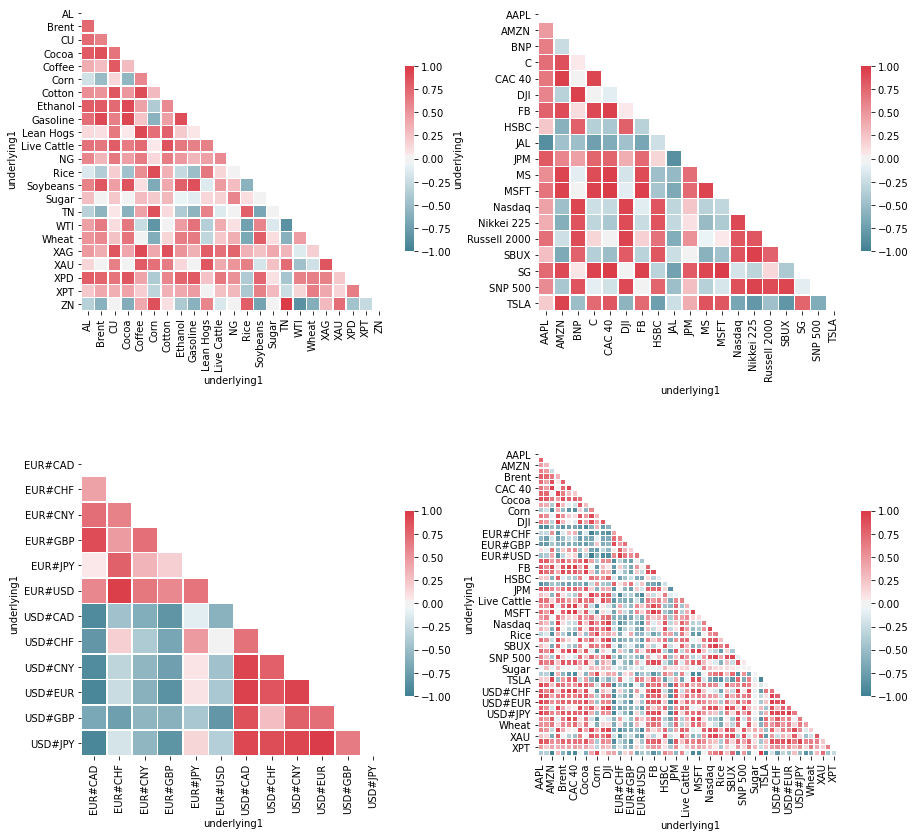

In [34]:
#Plot Covariance matrix as a heatmap

allFormat2 = allFormat.loc[allFormat.index>corrDate]

corrAll, maskALL = stsp.corrParam(allFormat2)
corrEQD, maskEQD = stsp.corrParam(EQDFormat)
corrCTY, maskCTY = stsp.corrParam(CTYFormat)
corrFX, maskFX = stsp.corrParam(FXFormat)

fig,((ax1,ax2),(ax3,ax4)) =  plt.subplots(2,2,figsize=(15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrCTY, mask=maskCTY,cmap=cmap,vmax = 1, center=0, vmin =-1, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
sns.heatmap(corrEQD, mask=maskEQD,cmap=cmap,vmax = 1, center=0, vmin =-1, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
sns.heatmap(corrFX, mask=maskFX,cmap=cmap,vmax = 1, center=0, vmin =-1, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
sns.heatmap(corrAll, mask=maskALL,cmap=cmap,vmax = 1, center=0, vmin =-1, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax4)

fig.tight_layout(pad=70.0)

plt.plot()

## Heteroscedasticity 

A processus $(x_1, x_2, x_3, ..., x_n)$ is heteroscedastic if the variability of the residual is different throughout its element. In finance, it usually measure the variance or the volatility of a specific underlying, in our case it is the gold.<br>

Let $y_i = \alpha x_i + \epsilon_i, \forall i \in [1:N]$ be a random processus which can be splitted into a determinist part being $\alpha$ the matrix of coefficient, X and its random part being $\epsilon$ the residuals.<br>
The data are homoskedastic if $\mathcal{V}(\epsilon_i)=\sigma^2$ with $\sigma$ constant, if not the processus is heteroskedastic.<br>

More generaly<br>
$\begin{pmatrix}y_1\\y_2\\.\\.\\y_n \end{pmatrix} = 
\alpha X + \epsilon  = 
\begin{pmatrix}\alpha_1 &0&0&0&0\\0&\alpha_2&0&0&0\\.&.&.&.&.\\.&.&.&.&.\\0&0&0&0& \alpha_n \end{pmatrix}
\begin{pmatrix}x_1\\x_2\\.\\.\\x_n \end{pmatrix} + 
\begin{pmatrix}\epsilon_1\\ \epsilon_2\\.\\.\\ \epsilon_n \end{pmatrix}$

with,
$\mathcal{L}(\epsilon_i)=\mathcal{L}(\mu,\sigma^2(\omega))$<br>

The only random part is the residual.<br>
Lets decompose the stationarised data to have a proper look on the residuals.

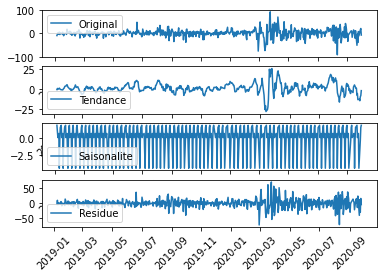

In [35]:
xauDecomposition = seasonal_decompose(xauTransform.diff1, period=7)
xauTrend = xauDecomposition.trend
xauSeasonal = xauDecomposition.seasonal
xauResidual = xauDecomposition.resid

#xauDecomposition.plot()
plt.subplot(411)
plt.plot(xauTransform.diff1,label="Original")
plt.xticks(rotation=45);
plt.legend(loc='best')
plt.subplot(412)

plt.plot(xauTrend,label="Tendance")
plt.xticks(rotation=45);
plt.legend(loc='best')
plt.subplot(413)

plt.plot(xauSeasonal,label="Saisonalite")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.subplot(414)

plt.plot(xauResidual,label="Residue")
plt.xticks(rotation=45)
plt.legend(loc='best');

## Variance
$$ \sigma^2 = \frac{\sum^N_{i=1}(x_i-\bar{x})^2}{N-1}$$
<br>
with:<br>
N sample size <br>
N-1 degree of freedom<br>
$\bar x$ mean of the data

# Historical volatility
Volatility is a statistical measure of the dispersion of returns for a given security or market index. In most cases, the higher the volatility, the riskier the security. Volatility is often measured as either the standard deviation or variance between returns from that same security or market index.
## Annual volatility

$$Volatility_{Annual}=\sqrt{252}*Volatility_{daily}$$

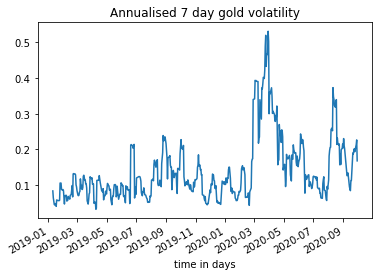

In [36]:
xauTransform['vol'] = xau.XAU.pct_change().rolling(7).std()*(252**0.5) #TO CHANGE FOR XAUTRANSFORM, ADD INTO XAU
xauTransform['vol'].plot()
plt.title('Annualised 7 day gold volatility')
plt.xlabel('time in days');

The above plot describes the annualised volatility, the most significant variation is arround 2020-03. The main cause is the significant drop of about 25% that happened when first lockdown was imposed worldwide. Thus, variance is not constant throughout time and it is a deal breaker for the ARIMA model. We need to modelise the volatility or the variance of the residuals as a random variable throughout time. 

## Distribution law of residual

### Gaussian test

### Student T test


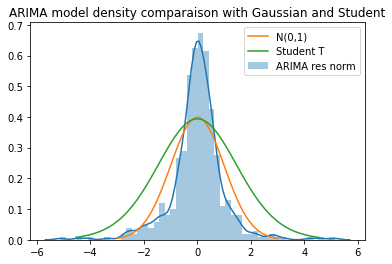

In [37]:
sns.distplot(stsp.standardized(fit.resid),label="ARIMA res norm");
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),label='N(0,1)')

rv = t(df=20, loc=0, scale=1)
xt = np.linspace(rv.ppf(0.0001), rv.ppf(0.9999), 100)
yt = rv.pdf(x) 

plt.plot(xt,yt,label='Student T')
plt.legend(loc='best')
plt.title("ARIMA model density comparaison with Gaussian and Student")
plt.show()


# GARCH

## GARCH Model
The autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods error terms, often the variance is related to the squares of the previous innovations. The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model, if an autoregressive moving average (ARMA) model is assumed for the error variance, the model is a generalized autoregressive conditional heteroskedasticity (GARCH) model.

$X^2_t = \epsilon_t^2 (\omega+\alpha_1 X_{t-1}^2+\alpha_2 X_{t-2}^2+ ... +\beta_1 \sigma^2_{t-1}+\beta_2 \sigma^2_{t-2}+...)$

with:

$\epsilon ~ N(0,1)$

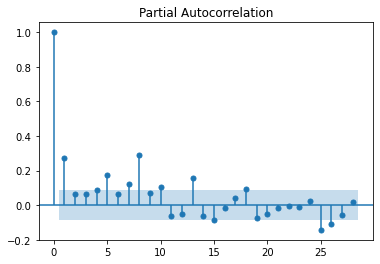

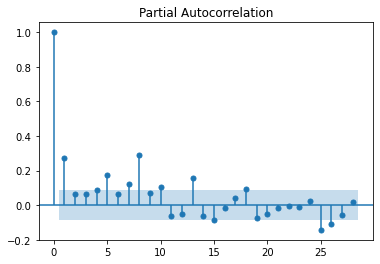

In [38]:
returns = xau.pct_change().dropna()**2
plot_pacf(returns)

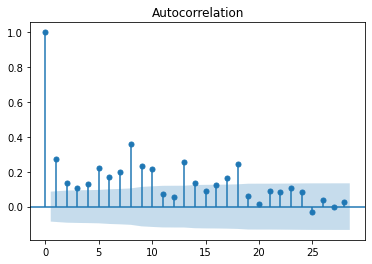

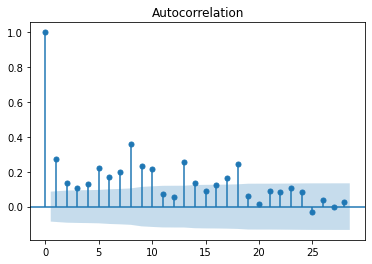

In [39]:
plot_acf(returns)

In [57]:
garchModel = arch_model(returns, p=1,q=1)
garchFit = garchModel.fit();
garchFit.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3661.6386291909807
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3661.6386285698454
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
C:\Users\Franck\AppData\Local\Programs\Python\Python38-32\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    XAU   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3661.64
Distribution:                  Normal   AIC:                          -7315.28
Method:            Maximum Likelihood   BIC:                          -7298.26
                                        No. Observations:                  520
Date:                Sat, Oct 17 2020   Df Residuals:                      516
Time:                        01:40:37   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0618e-04  9.282e-08   1143.942      0.000 [1.060e-04,1.064e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.5333e-09  4.155e-12   2053.562      0.000 [8.525e-09,8.541e-09]
alpha[1]       0.2000  7.781e-02      2.570  1.016e-02   [4.750e-02,  0.352]
beta[1]        0.7000  7.345e-02      9.530  1.567e-21     [  0.556,  0.844]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

In [51]:
%%capture
arimaResid = model.fit().resid
type = ['GARCH','ARCH','EGARCH']#, 'FIARCH','HARCH'
law = ['generalized error','skewt','normal','studentst']
am = arch_model(arimaResid, vol='GARCH', p=1, q=1, dist='generalized error')  # boucle sur les type de garch + type de loi
fit = am.fit()
residuals = pd.DataFrame()  # ljung box sur les residus + kolmogorov

for i in type:
    for j in law:
        am = arch_model(xauTransform.diff1,vol=i,p=2,q=2,dist=j)#boucle sur les type de garch + type de loi
        fit = am.fit()
        resi = fit.resid;#ljung box sur les residus + kolmogorov
        residuals[i+' '+j] = resi;

In [54]:
ljung_result=None
ljung_result = pd.DataFrame()
ljung_result['type'] = 'GARCH generalized error'

for i in residuals.columns:
    ljungIndex = acorr_ljungbox(residuals[i],return_df=True,lags=10)
    ljungIndex['type'] = i
    ljung_result = ljung_result.append(ljungIndex)

### Engle 

Engle test hetorosedasticity of residuals

In [57]:
engle_result = None
engle_result = pd.DataFrame()

for i in residuals.columns:
    engle_index = pd.DataFrame(engle(residuals[i]))
    engle_index['type'] = i
    engle_result = engle_result.append(engle_index)
